#### INTERCEPTOR project | Code for clinical feature model 

In [1]:
env:SCIPY_ARRAY_API=1

env: :SCIPY_ARRAY_API=1


In [1]:
#import libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [62]:
### Load and preprocess data ###
#put your directory path of the dataset here, makes sure file format is .csv
file = r"C:\\Users\\soogy\\Desktop\\Dataset INTERCEPTOR compleet included niet anoniem 02-09-2025.csv"
df = pd.read_csv(file, na_values=['NaN', ' '], encoding='utf-8', on_bad_lines='warn', sep=';')

pcr_column = 'pCR'
exclude_cols = ['PAnummer',  'pCR', 'ASA_Score', 'PreCEA', 'PreDefa', 'Preoperative_CTx']
X = df.drop(columns=exclude_cols)
y = df['pCR'].astype(int)

X['Geslacht'] = X['Geslacht'].map({'v': 0, 'm': 1}) #sex to binary

for col in X.columns:
    if col == 'Weight' or col == 'BMI':
        continue
    X[col] = X[col].replace(999, np.nan)
    X[col] = X[col].replace('999', np.nan)

for col in X.columns:
    X[col] = X[col].astype(str).str.replace(',', '.', regex=False)
    try:
        X[col] = X[col].astype(float)
    except ValueError:
        pass

#print(X.isnull().sum())
X = X.dropna()
y = y.loc[X.index]
#print(X.info())



X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=2025, stratify=y
)

for col in ['Weight', 'BMI']:
    for df_ in [X_train, X_val]:
        df_[col] = df_[col].astype(str).str.replace(',', '.', regex=False).astype(float)
        df_[col] = df_[col].replace(999, df_[col].median())

##Summary of data composition##
print(f"Train: {X_train.shape[0]}")
print(f"Train set positive: {np.sum(y_train == 1)}, negative: {np.sum(y_train == 0)}")
print(f"Validation: {X_val.shape[0]}")
print(f"Validation set positive: {np.sum(y_val == 1)}, negative: {np.sum(y_val == 0)}")



Train: 174
Train set positive: 24, negative: 150
Validation: 44
Validation set positive: 6, negative: 38


In [66]:
### Feature Selection ###
feature_model = ['Positive_nodes_number', 'Endoscopic_tumor_height'] # you can modify this list based on feature you want to use
X_train_sel = X_train[feature_model]
X_val_sel = X_val[feature_model]
print(f"Train: {X_train_sel.shape[0]}")
print(f"Train set positive: {np.sum(y_train == 1)}, negative: {np.sum(y_train == 0)}")
print(f"Validation: {X_val_sel.shape[0]}")
print(f"Validation set positive: {np.sum(y_val == 1)}, negative: {np.sum(y_val == 0)}")


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_val_scaled = scaler.transform(X_val_sel)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: w for i, w in zip(np.unique(y_train), class_weights)}
pos_class_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)
print("Class weights:", class_weights, "scale_pos_weight:", class_weight_dict[1]) # we use class weight as we have imbalanced dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    random_state=42,
    learning_rate=0.01,
    scale_pos_weight=pos_class_weight,
    max_delta_step=1,
    objective='binary:logistic'
)

auc_scores = []
train_fprs, train_tprs, train_aucs = [], [], []
val_fprs, val_tprs, val_aucs = [], [], []
fold = 1

for train_idx, val_idx in cv.split(X_train_scaled, y_train):
    X_tr, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb_model.fit(X_tr, y_tr)

    # Train ROC curve
    y_prob_train = xgb_model.predict_proba(X_tr)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_tr, y_prob_train)
    auc_train = roc_auc_score(y_tr, y_prob_train)
    train_fprs.append(fpr_train)
    train_tprs.append(tpr_train)
    train_aucs.append(auc_train)

    # Validation ROC curve
    y_prob_val = xgb_model.predict_proba(X_val_fold)[:, 1]
    fpr_val, tpr_val, _ = roc_curve(y_val_fold, y_prob_val)
    auc_val = roc_auc_score(y_val_fold, y_prob_val)
    val_fprs.append(fpr_val)
    val_tprs.append(tpr_val)
    val_aucs.append(auc_val)

    auc_scores.append(auc_val)
    fold += 1


Train: 174
Train set positive: 24, negative: 150
Validation: 44
Validation set positive: 6, negative: 38
Class weights: [0.58  3.625] scale_pos_weight: 3.625


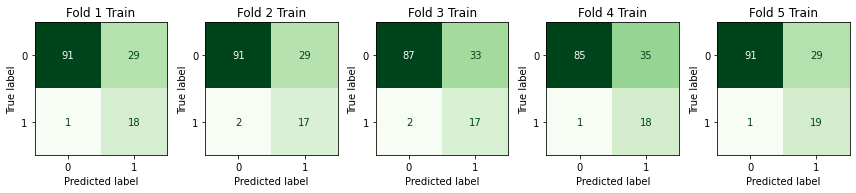

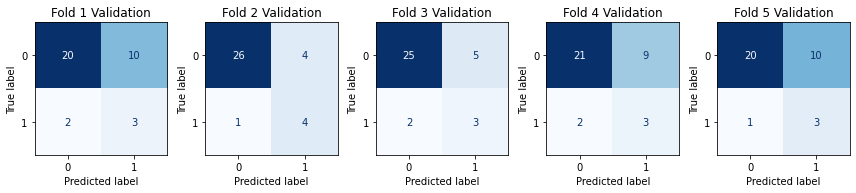

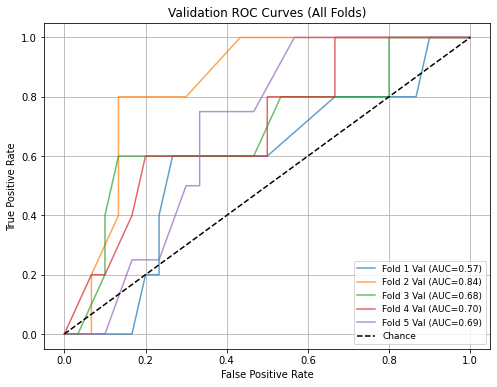


Mean Validation ROC-AUC: 0.6962
Used feature: ['Positive_nodes_number', 'Endoscopic_tumor_height']
Sensitivity: 0.670 ± 0.087
Specificity: 0.747 ± 0.086
PPV: 0.317 ± 0.106
NPV: 0.933 ± 0.021
F1-score: 0.423 ± 0.106
Balanced Acc: 0.708 ± 0.070


In [67]:
# Evaluation metrics and visualization 
sensitivities = []
specificities = []
ppvs = []
npvs = []
f1_scores = []
balanced_accuracies = []

plt.figure(figsize=(12, 4)) #train confusion matrix
for i, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train)):
    X_tr, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb_model.fit(X_tr, y_tr)
    y_pred_train = xgb_model.predict(X_tr)
    cm_train = confusion_matrix(y_tr, y_pred_train)
    plt.subplot(1, cv.n_splits, i+1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp.plot(cmap='Greens', ax=plt.gca(), colorbar=False)
    plt.title(f'Fold {i+1} Train')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4)) #validation confusion matrix
for i, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train)):
    X_tr, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb_model.fit(X_tr, y_tr)
    y_pred_val = xgb_model.predict(X_val_fold)
    cm_val = confusion_matrix(y_val_fold, y_pred_val)
    plt.subplot(1, cv.n_splits, i+1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_val)
    disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
    plt.title(f'Fold {i+1} Validation')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6)) #validation ROC curves
for i in range(len(val_fprs)):
    plt.plot(val_fprs[i], val_tprs[i], label=f'Fold {i+1} Val (AUC={val_aucs[i]:.2f})', alpha=0.7)
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curves (All Folds)')
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.show()

print(f"\nMean Validation ROC-AUC: {np.mean(auc_scores):.4f}")
print("Used feature:", feature_model)


for i, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train)):
    X_tr, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb_model.fit(X_tr, y_tr)
    y_pred_val = xgb_model.predict(X_val_fold)
    cm_val = confusion_matrix(y_val_fold, y_pred_val)
    tn, fp, fn, tp = cm_val.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    f1 = f1_score(y_val_fold, y_pred_val)
    balanced_acc = balanced_accuracy_score(y_val_fold, y_pred_val)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    ppvs.append(ppv)
    npvs.append(npv)
    f1_scores.append(f1)
    balanced_accuracies.append(balanced_acc)

print(f"Sensitivity: {np.mean(sensitivities):.3f} ± {np.std(sensitivities):.3f}")
print(f"Specificity: {np.mean(specificities):.3f} ± {np.std(specificities):.3f}")
print(f"PPV: {np.mean(ppvs):.3f} ± {np.std(ppvs):.3f}")
print(f"NPV: {np.mean(npvs):.3f} ± {np.std(npvs):.3f}")
print(f"F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
print(f"Balanced Acc: {np.mean(balanced_accuracies):.3f} ± {np.std(balanced_accuracies):.3f}")

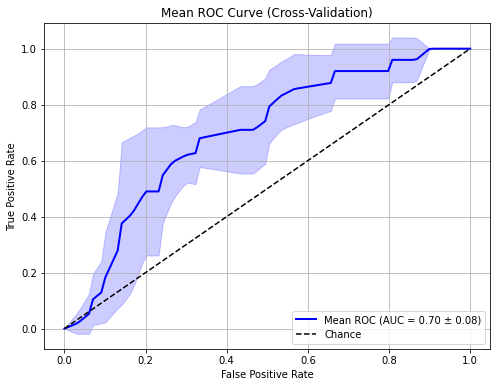

In [68]:
# roc curve with mean and std
from sklearn.metrics import roc_curve, auc

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

plt.figure(figsize=(8, 6))
for i, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train)):
    X_tr, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb_model.fit(X_tr, y_tr)
    y_pred_proba_val = xgb_model.predict_proba(X_val_fold)[:, 1]
    fpr, tpr, _ = roc_curve(y_val_fold, y_pred_proba_val)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    # Interpolate TPR
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

# Calculate mean and std
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='blue', alpha=0.2)
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve (Cross-Validation)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#### Feature importance visualization 

##### Shap Values

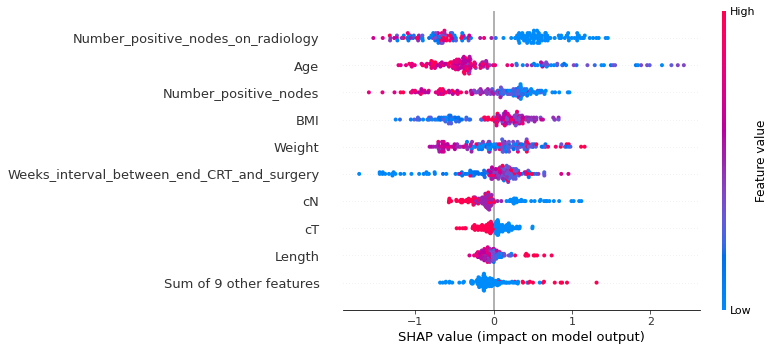

In [69]:
### SHAP Analysis and Visualization ###
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #full features for visualization
X_val_scaled = scaler.transform(X_val)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
pos_class_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)

xgb_model_shap = xgb.XGBClassifier(
    n_estimators=500,
    random_state=42,
    learning_rate=0.01,
    scale_pos_weight=pos_class_weight,
    max_delta_step=1,
    objective='binary:logistic'
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []
train_fprs, train_tprs, train_aucs = [], [], []
val_fprs, val_tprs, val_aucs = [], [], []


for train_idx, val_idx in cv.split(X_train_scaled, y_train):
    X_tr, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb_model_shap.fit(X_tr, y_tr)

    y_prob_train = xgb_model_shap.predict_proba(X_tr)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_tr, y_prob_train)
    auc_train = roc_auc_score(y_tr, y_prob_train)
    train_fprs.append(fpr_train)
    train_tprs.append(tpr_train)
    train_aucs.append(auc_train)

    y_prob_val = xgb_model_shap.predict_proba(X_val_fold)[:, 1]
    fpr_val, tpr_val, _ = roc_curve(y_val_fold, y_prob_val)
    auc_val = roc_auc_score(y_val_fold, y_prob_val)
    val_fprs.append(fpr_val)
    val_tprs.append(tpr_val)
    val_aucs.append(auc_val)
    auc_scores.append(auc_val)


rename_dict = {
    'cN_TNM': 'cN',
    'Weight': 'Weight',
    'Endoscopic_tumor_height': 'Distance_to_anorectal_junction',
    'BMI': 'BMI',
    'DateDIFF_OK_RTx_weeks': 'Weeks_interval_between_end_CRT_and_surgery',
    'Positive_nodes_number': 'Number_positive_nodes_on_radiology',
    'Age': 'Age',
    'Number_nodes': 'Number_positive_nodes',
    'Geslacht': 'Sex',
    'cT_TNM': 'cT',
    'cM_TNM': 'cM'
}
X_train_df_shap = pd.DataFrame(X_train_scaled, columns=X_train.columns).rename(columns=rename_dict)

explainer = shap.Explainer(xgb_model_shap, X_train_df_shap)
shap_values = explainer(X_train_df_shap)

shap.plots.beeswarm(shap_values)

##### XGBoost Feature Importance Ranking

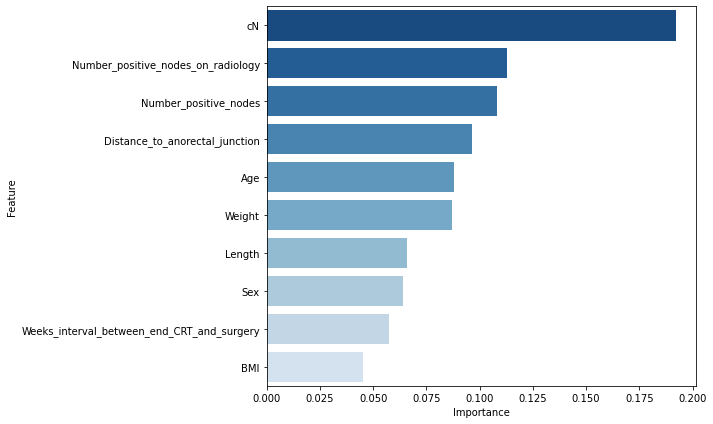

In [73]:
import matplotlib.colors as mcolors


exclude_cols = [
'Pre_OK_klachten', 'Total_dose_RTx', 'PreStagL'
]

feature_names = [col for col in X_train.columns if col not in exclude_cols]
feature_importances = xgb_model_shap.feature_importances_

if len(feature_importances) != len(feature_names):
    X_train_filtered = X_train.drop(columns=exclude_cols)
    X_train_scaled_filtered = StandardScaler().fit_transform(X_train_filtered)
    xgb_model_shap.fit(X_train_scaled_filtered, y_train)
    feature_importances = xgb_model_shap.feature_importances_
    feature_names = X_train_filtered.columns

rename_dict = {
    'cN_TNM': 'cN',
    'Weight': 'Weight',
    'Endoscopic_tumor_height': 'Distance_to_anorectal_junction',
    'BMI': 'BMI',
    'DateDIFF_OK_RTx_weeks': 'Weeks_interval_between_end_CRT_and_surgery',
    'Positive_nodes_number': 'Number_positive_nodes_on_radiology',
    'Age': 'Age',
    'Number_nodes': 'Number_positive_nodes',
    'Geslacht': 'Sex',
    'cT_TNM': 'cT',
    'cM_TNM': 'cM'
}

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)
feature_importance_df['Feature'] = feature_importance_df['Feature'].replace(rename_dict)

top_n = 10
top_features = feature_importance_df.head(top_n)
colors = [mcolors.to_hex(c) for c in plt.cm.Blues(np.linspace(0.9, 0.2, top_n))]

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=top_features,
    palette=colors
)
#plt.title(f'XGBoost Feature Importances (Top {top_n})')
plt.tight_layout()
plt.show()